In [1]:
import car_racing as cr
import replay_memory as rm
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim

In [2]:
env_green = cr.CarRacing(color = 'g')
obs = env_green.reset()

env_red = cr.CarRacing(color = 'r')
obs = env_red.reset()

env_blue = cr.CarRacing(color = 'b')
obs = env_blue.reset()

c:\Users\55366\anaconda3\envs\ml\lib\site-packages\gym\spaces\box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Track generation: 988..1239 -> 251-tiles track


c:\Users\55366\anaconda3\envs\ml\lib\site-packages\pyglet\image\codecs\wic.py:434: UserWarning: [WinError -2147417850] 无法在设置线程模式后对其加以更改。
  warnings.warn(str(err))


Track generation: 1172..1469 -> 297-tiles track
Track generation: 1175..1474 -> 299-tiles track


In [3]:
obs_array = []
discrete_actions = {0 : np.array([0,0,0]),       # do nothing
                                 1 : np.array([-1,0,0]),      # steer sharp left
                                 2 : np.array([1,0,0]),       # steer sharp right
                                 3 : np.array([-0.5,0,0]),    # steer left
                                 4 : np.array([0.5,0,0]),     # steer right
                                 5 : np.array([0,1,0]),       # accelerate 100%
                                 6 : np.array([0,0.5,0]),     # accelerate 50%
                                 7 : np.array([0,0.25,0]),    # accelerate 25%
                                 8 : np.array([0,0,1]),       # brake 100%
                                 9 : np.array([0,0,0.5]),     # brake 50%
                                 10 : np.array([0,0,0.25])}   # brake 25%

In [4]:
def get_obs(env):
    obs_array = []
    n_actions = len(discrete_actions)
    for i in range (0, 40):
        action = torch.randint(low=0, high=11, size=(1,))
        action_transfered = discrete_actions.get(int(action[0]))

        obs, reward, done, _ = env.step([action_transfered[0], action_transfered[1], action_transfered[2]])
        if (i % 4 == 0):
            obs_array.append(obs)

    return obs_array

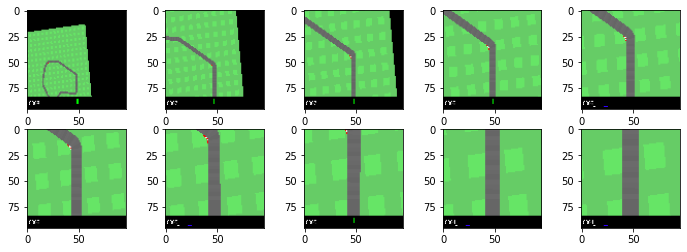

In [5]:
f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
obs_array = get_obs(env_green)
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

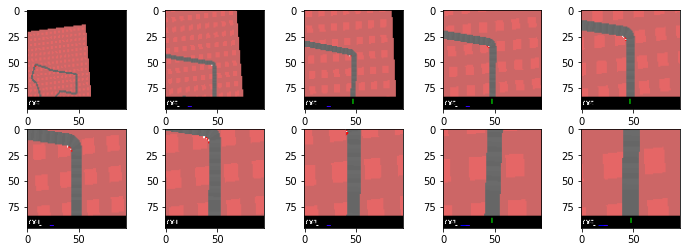

In [6]:
f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
obs_array = get_obs(env_red)
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

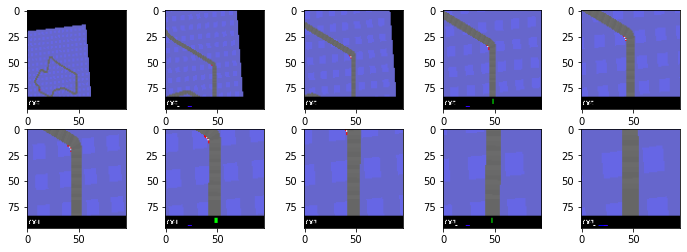

In [7]:
f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
obs_array = get_obs(env_blue)
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

In [8]:
env_green.close()
env_red.close()
env_blue.close()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import numpy as np
import datetime
import gym

import numpy as np

import matplotlib.pyplot as plt

In [6]:
env = gym.make('CarRacing-v1')

In [39]:
car_list = []
file_list = []

In [40]:
for i in range(0, 2):
    for j in range(1, 6):
        path = './carracing_data_full/car{}/{}.npz'.format(j, i)
        car_list.append( np.load(path))

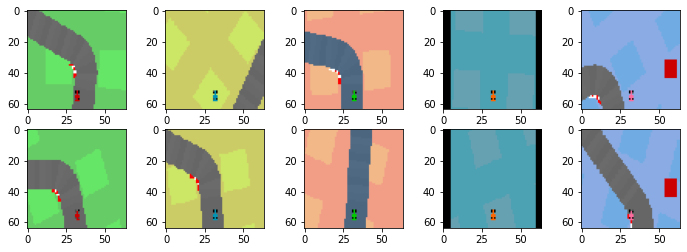

In [41]:
obs_array = []
 
for k in range(2):
    for i in range (5):
        n = np.random.randint(0, 200000)
        sample_image = car_list[i]['obs'][n]
        obs_array.append(sample_image)

f, axs = plt.subplots(2,5, figsize = (12, 4))

axs = axs.flatten()
for img, ax in zip(obs_array, axs):
    ax.imshow(img)
plt.show()

# PPO (https://github.com/xtma/pytorch_car_caring/blob/master/train.py)

## Environment settings

In [3]:
def rgb2gray(rgb, norm=True):
    # rgb image -> gray [0, 1]
    gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    if norm:
        # normalize
        gray = gray / 128. - 1.
    return gray

In [4]:
img_rgb = env.reset()
img_gray = rgb2gray(img_rgb)

Track generation: 1141..1430 -> 289-tiles track


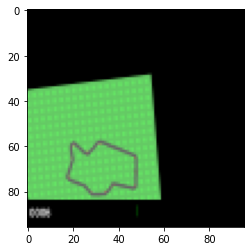

In [5]:
plt.imshow(img_rgb)

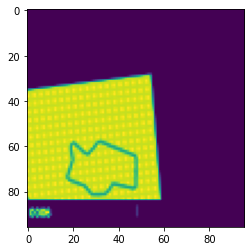

In [6]:
plt.imshow(img_gray)

In [7]:
class Env():
    def __init__(self, env):
        self.env = env
        self.env.seed(0)
        self.reward_threshold = self.env.spec.reward_threshold

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = self.env.reset()
        img_gray = rgb2gray(img_rgb)
        self.stack = [img_gray] * 4  # four frames for decision
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for i in range(8):
            img_rgb, reward, die, _ = self.env.step(action)
            # don't penalize "die state"
            if die:
                reward += 100
            # green penalty
            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward
            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False
            if done or die:
                break
        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == 4
        return np.array(self.stack), total_reward, done, die

    def render(self, *arg):
        self.env.render(*arg)

    @staticmethod
    def reward_memory():
        # record reward for last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory

In [8]:
env_warrper = Env(env=env)
state = env_warrper.reset()

Track generation: 1265..1585 -> 320-tiles track


In [9]:
print (state.shape)
print (env_warrper.reward_threshold)
print (len(env_warrper.stack))
print (env_warrper.stack[0].shape)

(4, 96, 96)
900
4
(96, 96)


## Actor Critic for ppo

In [10]:
class Net(nn.Module):
    """
    Actor-Critic Network for PPO
    """

    def __init__(self):
        super(Net, self).__init__()
        self.cnn_base = nn.Sequential(  # input shape (4, 96, 96)
            nn.Conv2d(4, 8, kernel_size=4, stride=2),
            nn.ReLU(),  # activation
            nn.Conv2d(8, 16, kernel_size=3, stride=2),  # (8, 47, 47)
            nn.ReLU(),  # activation
            nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (16, 23, 23)
            nn.ReLU(),  # activation
            nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (32, 11, 11)
            nn.ReLU(),  # activation
            nn.Conv2d(64, 128, kernel_size=3, stride=1),  # (64, 5, 5)
            nn.ReLU(),  # activation
            nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (128, 3, 3)
            nn.ReLU(),  # activation
        )  # output shape (256, 1, 1)
        self.v = nn.Sequential(nn.Linear(256, 100), nn.ReLU(), nn.Linear(100, 1))
        self.fc = nn.Sequential(nn.Linear(256, 100), nn.ReLU())
        self.alpha_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.beta_head = nn.Sequential(nn.Linear(100, 3), nn.Softplus())
        self.apply(self._weights_init)

    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1

        return (alpha, beta), v

In [11]:
ac = Net()
state = torch.randn((4, 96, 96))
(alpha, beta), v = ac(state)

In [17]:
print(alpha.size())
print(beta.size())
print(v.size())

torch.Size([1, 3])
torch.Size([1, 3])
torch.Size([1, 1])


## Agent

In [19]:
(alpha, beta), v = ac(state)

In [18]:
from torch.distributions import Beta

In [24]:
x = Beta(alpha, beta)
action = x.sample()

In [25]:
a_logp = x.log_prob(action).sum(dim=1)

In [26]:
a_logp

tensor([0.1480], grad_fn=<SumBackward1>)

# DQN (https://arxiv.org/pdf/2109.04155.pdf)

## enviorment setup

In [117]:
obs = env.reset()

Track generation: 1067..1338 -> 271-tiles track


In [118]:
preprocess = T.Compose([
                T.ToPILImage(),
                T.Grayscale(num_output_channels=1),
                T.Resize((42, 42)),
                T.ToTensor()])

In [119]:
obs = env.reset()

Track generation: 1192..1494 -> 302-tiles track


## State preprocess

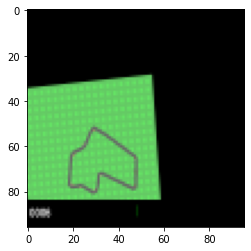

In [120]:
plt.imshow(obs)

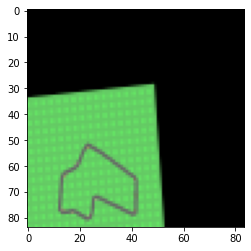

In [121]:
tran = obs.transpose((2, 1, 0))
stip = tran[:, 6:90, int(96*0):int(96 * 0.875)]
plt.imshow(stip.transpose((2, 1, 0)))

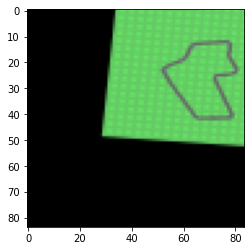

In [122]:
filped = np.flip(stip, axis=0)
x_1 = torch.from_numpy(filped.copy())
to_image = T.ToPILImage()
img_1 = to_image(x_1)
plt.imshow(img_1)

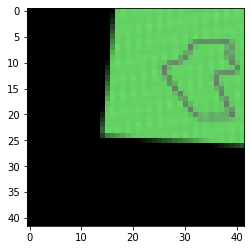

In [123]:
resize = T.Resize((42, 42))
img_2 = resize(x_1)
img_2 = to_image(img_2)
plt.imshow(img_2)

In [124]:
def convert_observation(obs):
    # shape observation to original size 96x96 with 3 rgb channels
    obs = obs.reshape(96, 96, 3)
    obs = obs.transpose((2, 1, 0))
        
    # stips of bottom part of the image which contains a black bar with the accumulated reward and control value bars, and makes sure width is equal to height
    obs = obs[:, 6:90, int(96*0):int(96 * 0.875)]
        
    # grayscale and resize
    obs = preprocess(torch.from_numpy(np.flip(obs, axis=0).copy()))      
        
    return obs

In [125]:
obs = convert_observation(obs)

In [126]:
obs.shape

torch.Size([1, 42, 42])

## observation batch

In [127]:
obs_batch = np.array([np.zeros((42, 42), dtype = 'float32') for i in range(8)])

In [128]:
print(obs_batch.shape)

(8, 42, 42)


(8, 42, 42)


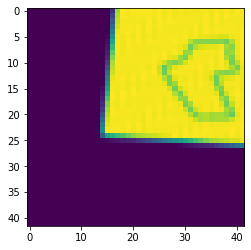

In [129]:
obs_batch = np.concatenate((obs.numpy(), obs_batch[0:7]), axis = 0)
print(obs_batch.shape)

plt.imshow(obs_batch[0])

In [130]:
obs_batch2 = torch.from_numpy(np.flip(obs_batch, axis=0).copy())
obs_batch2[-1].size()

torch.Size([42, 42])

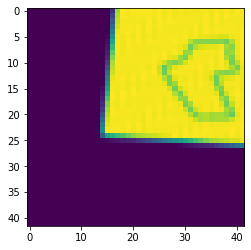

In [131]:
img = obs_batch2[-1].numpy()
plt.imshow(img)

In [132]:
obs_batch2 = obs_batch2.unsqueeze(0)
obs_batch2.size()

torch.Size([1, 8, 42, 42])

In [133]:
def get_obs_batch(obs):
    # add new observation to obs_batch, remove oldest.
    obs_batch = np.concatenate((obs.numpy(), obs_batch[0:7]), axis = 0)
        
    # resize to (1, self.n_screens, 84, 84) and convert to torch
    obs_batch2 = torch.from_numpy(np.flip(obs_batch, axis=0).copy()).unsqueeze(0)
     
    return obs_batch2


## learn stage

In [135]:
import replay_memory as rm

In [136]:
memory = rm.ReplayMemory( 30000, (42, 42), 1764, False, device='cuda')

In [138]:
print (memory.capacity)

30000


In [142]:
print(memory.obs_mem.size())
print(memory.action_mem.size())
print(memory.reward_mem.size())
print(memory.done_mem.size())

torch.Size([30000, 42, 42])
torch.Size([30000])
torch.Size([30000])
torch.Size([30000])


In [146]:
obs_indices = [9, 8, 7, 6, 5 ,4, 3, 2, 1, 0]
action_indices = [1]
reward_indices = [1]
done_indices = [0]
max_n_indices = 10
batch_size = 250

In [149]:
memory.push_count = 1000

In [150]:
all_batch, action_batch, reward_batch, done_batch = memory.sample(
    obs_indices, action_indices, reward_indices, done_indices,max_n_indices, batch_size
)

In [153]:
print(all_batch.size())
print(action_batch.size())
print(reward_batch.size())
print(done_batch.size())

torch.Size([250, 10, 42, 42])
torch.Size([250, 1])
torch.Size([250, 1])
torch.Size([250, 1])


In [155]:
obs_batch = all_batch[:, 0:8, :, :].view(250, 8, 42, 42)
obs_batch.size()

torch.Size([250, 8, 42, 42])

In [156]:
next_obs_batch = all_batch[:, 1:9, :, :].view(250, 8, 42, 42)
obs_batch.size()

torch.Size([250, 8, 42, 42])

In [157]:
class DQN(nn.Module):
    def __init__(self, n_screens, n_hidden, n_outputs, lr=0.001, device='cpu'):
        super(DQN, self).__init__()
        
        self.n_screens = n_screens # Number of stacked observations
        self.n_hidden = n_hidden   # Number of hidden units
        self.n_outputs = n_outputs # Number of outputs

        self.device = device
        
        # The convolutional encoder
        self.encoder = nn.Sequential(                
                nn.Conv2d(self.n_screens, 64, 4, stride=2), # (1, n_screens, 42, 42) --> (1, 64, 20, 20)
                nn.BatchNorm2d(64),
                nn.MaxPool2d(2, stride = 2),                # (1, 64, 20, 20) --> (1, 64, 10, 10)
                nn.ReLU(inplace=False),
                
                nn.Conv2d(64, 128, 4, stride=2),            # (1, 64, 10, 10) --> (1, 128, 4, 4)
                nn.BatchNorm2d(128),
                nn.MaxPool2d(2, stride = 2),                # (1, 128, 4, 4) --> (1, 128, 2, 2)
                nn.ReLU(inplace=False),
                
                nn.Conv2d(128, 256, 2, stride=2),           # (1, 128, 2, 2) --> (1, 256, 1, 1)
                nn.ReLU(inplace=False),
                
                ).to(self.device)
        
        # The size of the encoder output
        self.encoder_output_shape = (256, 1, 1) 
        self.encoder_output_size = np.prod(self.encoder_output_shape)
        
        self.fc1 = nn.Linear(self.encoder_output_size, self.n_hidden) # Hidden layer
        self.fc2 = nn.Linear(self.n_hidden, self.n_outputs)           # Output layer
        
        self.optimizer = optim.Adam(self.parameters(), lr)            # Adam optimizer
        
        self.to(self.device)

    def forward(self, x):
        # cast to device
        x = x.to(self.device)
        
        h1 = self.encoder(x)
        
        h2 = F.relu(self.fc1(h1.view(h1.size(0), -1)))
        
        y  = self.fc2(h2)
        
        return y

In [168]:
policy_net = DQN(n_screens = 8, n_hidden = 512, n_outputs= 11, lr= 0.001, device= 'cuda')
target_net = DQN(n_screens = 8, n_hidden = 512, n_outputs= 11, lr= 0.001, device= 'cuda')

In [164]:
value_batch = policy_net(obs_batch)
value_batch.size()

torch.Size([250, 11])

In [166]:
value_batch[0]

tensor([-0.0114,  0.0183,  0.0142, -0.0392, -0.0436, -0.0514,  0.0297,  0.0055,
         0.0284, -0.0530,  0.0237], device='cuda:0', grad_fn=<SelectBackward0>)

In [162]:
value_batch_2 = value_batch.gather(1, action_batch)

In [ ]:
gamma = 0.99

In [169]:
target_out = target_net(next_obs_batch)

In [ ]:
# (1-done_batch) is used to remove the samples which were gathered when the episode was done
target_batch = reward_batch + (1-done_batch) * gamma * target_out.max(1)[0]
target_batch = target_batch.view(250, 1)

In [ ]:
loss = F.mse_loss(target_batch, value_batch)

#